In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import sys
sys.path.append("../../../../src/")
import tunneling

from scipy.optimize import curve_fit
plt.style.use(["science","bright","grid"])

In [4]:
def get_linear_volt_ranges(N_x, N_y, ref_electrodes=[1,3], I_ref=1e-9, alpha=0.3):

    electrode_pos   = [[0,0],[int((N_x-1)/2),0],[N_x-1,0],[0,int((N_y-1)/2)],[0,N_y-1],
                       [N_x-1,int((N_y)/2)],[int((N_x)/2),(N_y-1)],[N_x-1,N_y-1]]
    electrode_type  = ['constant']*len(electrode_pos)
    lattice         = tunneling.NanoparticleTunneling(electrode_type)

    lattice.lattice_network(N_x, N_y)
    lattice.add_electrodes_to_lattice_net(electrode_pos)
    lattice.init_nanoparticle_radius()
    lattice.pack_planar_circles()
    lattice.init_adv_indices()
    lattice.init_junction_resistances()
    lattice.build_conductance_matrix()
    lattice.init_transfer_coeffs()
    lattice.calibrate_electrodes(ref_electrodes, I_ref, alpha)

    return lattice.get_delta_V()

In [ ]:
N_vals   = np.arange(3,17)
ref_idx  = [1,3]
delta_Vs = pd.DataFrame(np.array([get_linear_volt_ranges(N, N, ref_electrodes=ref_idx) for N in N_vals]))
delta_Vs

,0,1,2,3,4,5,6,7
0,0.112500,0.125000,0.056250,0.125000,0.056250,0.025000,0.025000,0.0
1,0.150000,0.166667,0.067500,0.166667,0.067500,0.021951,0.021951,0.0
2,0.125045,0.138118,0.074766,0.138118,0.074766,0.029490,0.029490,0.0
3,0.153045,0.164039,0.081168,0.164039,0.081168,0.027216,0.027216,0.0
4,0.134034,0.146057,0.085608,0.146057,0.085608,0.033099,0.033099,0.0
5,0.155586,0.164664,0.089974,0.164664,0.089974,0.031204,0.031204,0.0
6,0.141165,0.151881,0.093240,0.151881,0.093240,0.035960,0.035960,0.0
7,0.158530,0.166355,0.096562,0.166355,0.096562,0.034320,0.034320,0.0
8,0.147035,0.156513,0.099181,0.156513,0.099181,0.038304,0.038304,0.0
9,0.161538,0.168350,0.101868,0.168350,0.101868,0.036853,0.036853,0.0


Text(0, 0.5, '$U$ [mV]')

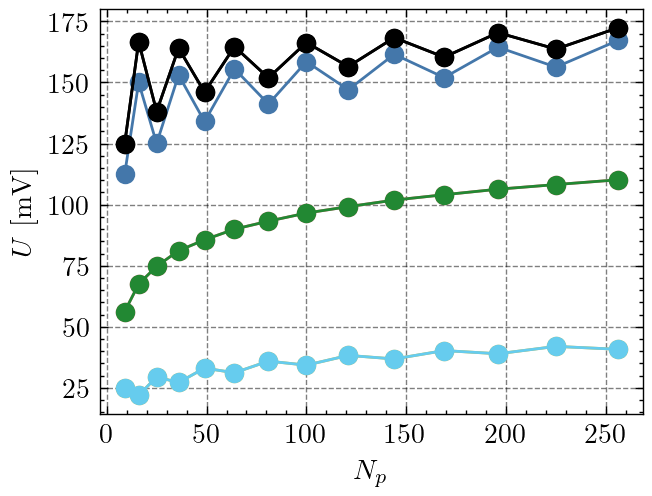

In [29]:
fig, ax = plt.subplots(dpi=200)
for e in range(7):
    if e not in ref_idx:
        ax.plot(N_vals**2, delta_Vs[e]*1000, 'o-')
    else:
        ax.plot(N_vals**2, delta_Vs[e]*1000, 'o-', color='black')
# ax.set_xscale('log')
ax.set_xlabel("$N_p$")
ax.set_ylabel("$U$ [mV]")

In [15]:
delta_Vs.values

array([[0.1125    , 0.125     , 0.05625   , 0.125     , 0.05625   ,
        0.025     , 0.025     , 0.        ],
       [0.15      , 0.16666667, 0.0675    , 0.16666667, 0.0675    ,
        0.02195122, 0.02195122, 0.        ],
       [0.12504504, 0.13811769, 0.07476563, 0.13811769, 0.07476563,
        0.02948982, 0.02948982, 0.        ],
       [0.15304508, 0.16403915, 0.08116776, 0.16403915, 0.08116776,
        0.02721614, 0.02721614, 0.        ],
       [0.13403398, 0.14605693, 0.08560834, 0.14605693, 0.08560834,
        0.03309865, 0.03309865, 0.        ],
       [0.15558584, 0.16466392, 0.08997384, 0.16466392, 0.08997384,
        0.03120355, 0.03120355, 0.        ],
       [0.14116484, 0.15188061, 0.09323995, 0.15188061, 0.09323995,
        0.03595991, 0.03595991, 0.        ],
       [0.15852965, 0.16635491, 0.09656172, 0.16635491, 0.09656172,
        0.03431975, 0.03431975, 0.        ],
       [0.147035  , 0.15651327, 0.09918098, 0.15651327, 0.09918098,
        0.03830358, 0.038303

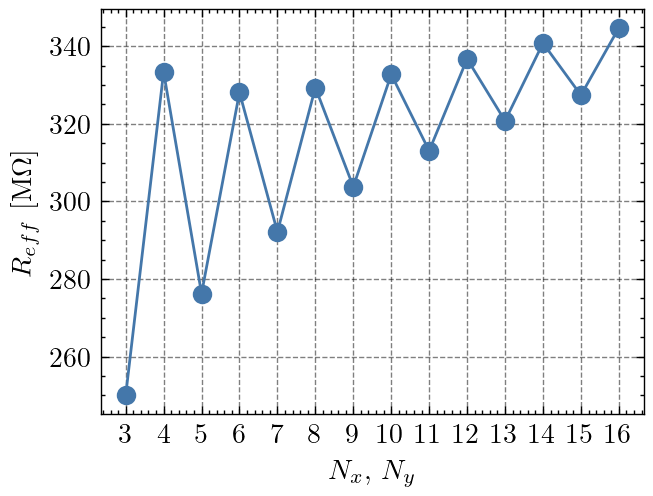

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(df[0],df[1]*1e-6,'-o')
ax.set_ylabel('$R_{eff}$ [M$\Omega$]')
ax.set_xlabel('$N_x$, $N_y$')
_ = ax.set_xticks(N_vals)

In [ ]:
def one_over_N(N,a,b,c):
    return a/(N-b) + c

p,_ = curve_fit(one_over_N, df[0].values, df[2].values)
p

array([ 4.11050819e-08, -5.53950101e+00,  1.62053375e-09])

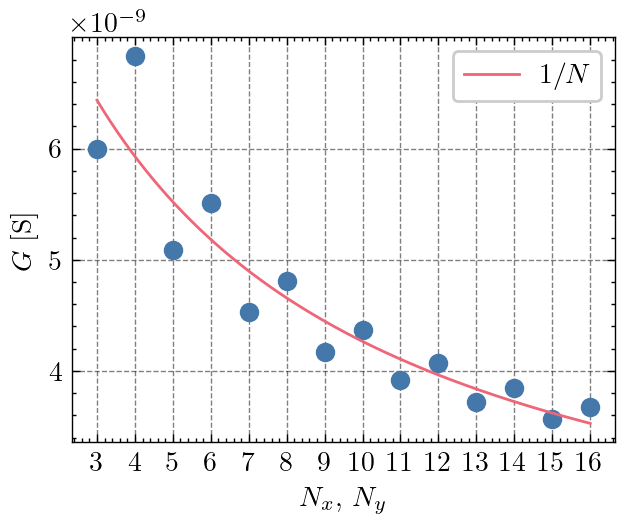

In [ ]:
x_val   = np.linspace(N_vals[0],N_vals[-1],1000,endpoint=True)
fig, ax = plt.subplots(dpi=200)
ax.plot(df[0], df[2], 'o')
ax.plot(x_val,one_over_N(x_val,*p),label='$1/N$')
ax.set_ylabel('$G$ [S]')
ax.set_xlabel('$N_x$, $N_y$')
ax.legend()
_ = ax.set_xticks(N_vals)

In [ ]:
input_idx       = [1,3]
control_idx     = [0,2,4,5,6]
R_eff_list      = []
C_impact_list   = []

for G in G_list:

    T_in    = G[input_idx] 
    R_eff   = 1 / np.sum(T_in)
    R_eff_list.append(R_eff)

    G_ctl       = G[control_idx]
    C_impact    = G_ctl / np.sum(T_in)
    C_impact_list.append(C_impact)

R_eff_arr       = np.array(R_eff_list)
C_impact_arr    = np.array(C_impact_list)

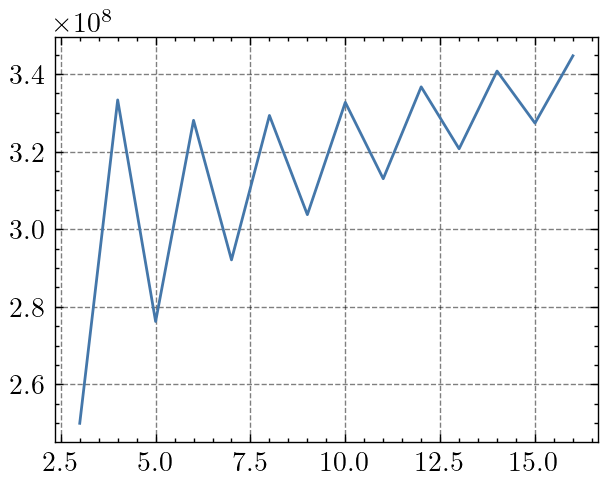

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(N_vals,R_eff_arr)

In [ ]:
C_impact_list

[array([0.33333333, 0.66666667, 0.66666667, 1.5       , 1.5       ]),
 array([0.33333333, 0.74074074, 0.74074074, 2.27777778, 2.27777778]),
 array([0.33136305, 0.55420262, 0.55420262, 1.40507152, 1.40507152]),
 array([0.32155065, 0.60629669, 0.60629669, 1.80818212, 1.80818212]),
 array([0.32691022, 0.51183188, 0.51183188, 1.32383265, 1.32383265]),
 array([0.31750433, 0.54903932, 0.54903932, 1.58312694, 1.58312694]),
 array([0.32277289, 0.4886766 , 0.4886766 , 1.26708265, 1.26708265]),
 array([0.31480846, 0.516835  , 0.516835  , 1.45416195, 1.45416195]),
 array([0.31933881, 0.47341718, 0.47341718, 1.22583782, 1.22583782]),
 array([0.31265093, 0.4957891 , 0.4957891 , 1.37044112, 1.37044112]),
 array([0.3165188 , 0.46231201, 0.46231201, 1.19433931, 1.19433931]),
 array([0.31083698, 0.48073915, 0.48073915, 1.31129289, 1.31129289]),
 array([0.31417727, 0.45372581, 0.45372581, 1.16929467, 1.16929467]),
 array([0.30927928, 0.46931729, 0.46931729, 1.26695462, 1.26695462])]

(0.1, 5.0)

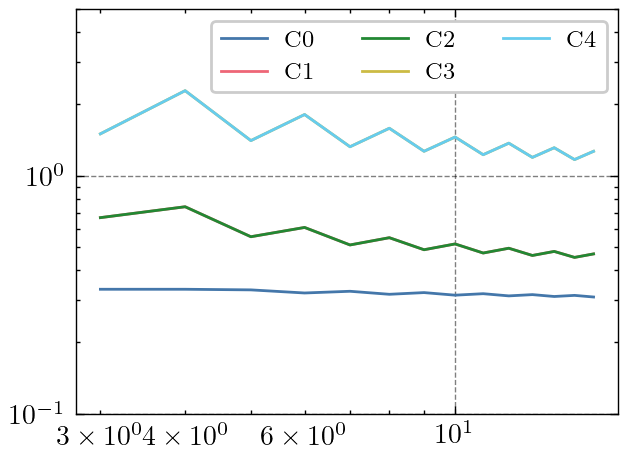

In [ ]:
fig, ax = plt.subplots(dpi=200)
for i in range(5):
    ax.plot(N_vals, C_impact_arr[:,i], label=f'C{i}')

ax.legend(fontsize='small',ncol=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-1,5e0)

In [ ]:
V_on    = 0.01
I_sat   = T_in.sum() * V_on
dV_C    = 0.30 * abs(I_sat) / max(abs(G_ctl))
print(f"Control voltages: use ±{dV_C*1e3:.1f} mV around 0")

Control voltages: use ±2.0 mV around 0
